# Multiclass Classification (Iris Dataset)

## Loading data

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris_data = load_iris()
X = iris_data["data"]
y = iris_data["target"]
class_names = iris_data["target_names"]
feature_names = iris_data["feature_names"]

In [2]:
X.shape

(150, 4)

In [3]:
y.shape

(150,)

In [4]:
class_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [5]:
feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

## Preprocessing the data

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

## Converting to PyTorch Dataset

In [7]:
import torch
from torch.utils.data import Dataset

class IrisDataset(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.labels = y

    def __getitem__(self, index):
        x = torch.tensor(self.data[index], dtype=torch.float32)
        label = torch.tensor(self.labels[index], dtype=torch.long)
        return (x, label)
    
    def __len__(self):
        return len(self.data)

In [8]:
train_ds = IrisDataset(X_train, y_train)
test_ds = IrisDataset(X_test, y_test)

len(train_ds), len(test_ds)

(120, 30)

In [9]:
train_ds[3]

(tensor([-1.2301,  0.7565, -1.2187, -1.3126]), tensor(0))

## Creating PyTorch DataLoaders

In [10]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=8,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=8,
    shuffle=False,
    num_workers=0
)

len(train_loader), len(test_loader)

(15, 4)

In [11]:
for (x, y) in train_loader:
    break

print(f"Input_batch:\n{x}")
print(f"target_batch:\n{y}")

Input_batch:
tensor([[-0.8645,  1.6508, -1.2187, -1.3126],
        [-0.8645,  0.9801, -1.3333, -1.3126],
        [-0.2550, -0.8086,  0.2712,  0.1557],
        [-1.1082, -1.4794, -0.2445, -0.2447],
        [-0.9863,  0.5329, -1.3333, -1.3126],
        [ 1.3297,  0.0857,  0.9589,  1.2236],
        [ 0.7202,  0.3093,  0.4432,  0.4227],
        [ 0.2326, -1.9266,  0.7297,  0.4227]])
target_batch:
tensor([0, 0, 1, 1, 0, 2, 1, 2])


## Creating Simple Neural Network Architecture

In [12]:
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 4)
        self.layer2 = nn.Linear(4, 4)
        self.out_layer = nn.Linear(4, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.out_layer(x)
        return x

In [13]:
class_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [14]:
torch.manual_seed(123)

model = SimpleNN(input_dim=X_train.shape[-1], num_classes=len(class_names))
with torch.no_grad():
    logits = model(x)

logits

tensor([[ 0.3752,  0.2492,  0.1007],
        [ 0.2952,  0.2389,  0.1440],
        [ 0.1150,  0.1937, -0.0591],
        [ 0.0343,  0.1955,  0.1207],
        [ 0.2424,  0.2322,  0.1885],
        [ 0.1336,  0.1958, -0.0610],
        [ 0.1336,  0.1958, -0.0610],
        [ 0.1122,  0.1937, -0.0568]])

In [15]:
# utility function to calculate accuracy
def calculate_loader_accuracy(data_loader, model):
    model.eval()
    num_samples = 0
    correct = 0
    for (x_batch, target_batch) in data_loader:
        with torch.no_grad():
            logits = model(x_batch)
        predicted_labels = torch.argmax(logits, dim=-1)
        correct += sum(predicted_labels == target_batch)
        num_samples += predicted_labels.shape[0]

    return (correct / num_samples).item()
    
    

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [17]:
# utility function to evaluate the model
def evaluate(data_loader, model):
    model.eval()
    num_samples = 0
    correct = 0
    total_loss = 0.0
    for (x_batch, target_batch) in data_loader:
        with torch.no_grad():
            logits = model(x_batch)
        loss = loss_fn(logits, target_batch)
        predicted_labels = torch.argmax(logits, dim=-1)
        correct += sum(predicted_labels == target_batch)
        num_samples += predicted_labels.shape[0]
        total_loss += loss.item()

    return (correct / num_samples).item(), (total_loss / len(data_loader))

## Simple PyTorch Training Loop

In [18]:
num_epochs = 200
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for (x_batch, y_batch) in train_loader:
        optimizer.zero_grad()
        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    train_loss = total_loss/len(train_loader)
    train_acc = calculate_loader_accuracy(train_loader, model)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Eval
    val_acc, val_loss = evaluate(test_loader, model)
    valid_losses.append(val_loss)
    valid_accuracies.append(val_acc)
    print(f"Epoch: {epoch+1:02d}/{num_epochs:02d}",
          f" | Train loss: {train_loss:.4f}"
          f" | Train acc: {train_acc:.4f}",
          f" | Valid loss: {val_loss:.4f}",
          f" | Valid acc: {val_acc:.4f}")


Epoch: 01/200  | Train loss: 1.0880 | Train acc: 0.6417  | Valid loss: 1.0992  | Valid acc: 0.6333
Epoch: 02/200  | Train loss: 1.0656 | Train acc: 0.6667  | Valid loss: 1.0789  | Valid acc: 0.6333
Epoch: 03/200  | Train loss: 1.0457 | Train acc: 0.6667  | Valid loss: 1.0594  | Valid acc: 0.6333
Epoch: 04/200  | Train loss: 1.0256 | Train acc: 0.6750  | Valid loss: 1.0407  | Valid acc: 0.6333
Epoch: 05/200  | Train loss: 1.0061 | Train acc: 0.6750  | Valid loss: 1.0213  | Valid acc: 0.6333
Epoch: 06/200  | Train loss: 0.9871 | Train acc: 0.6750  | Valid loss: 1.0012  | Valid acc: 0.6333
Epoch: 07/200  | Train loss: 0.9663 | Train acc: 0.6750  | Valid loss: 0.9810  | Valid acc: 0.6333
Epoch: 08/200  | Train loss: 0.9448 | Train acc: 0.6750  | Valid loss: 0.9590  | Valid acc: 0.6333
Epoch: 09/200  | Train loss: 0.9216 | Train acc: 0.6667  | Valid loss: 0.9361  | Valid acc: 0.6333
Epoch: 10/200  | Train loss: 0.8978 | Train acc: 0.6583  | Valid loss: 0.9134  | Valid acc: 0.6333
Epoch: 11/

In [19]:
# utility fuction to calculate batch accuracy
def calculate_batch_accuracy(logits, true_labels):
    predicted_labels = torch.argmax(logits, dim=-1)
    correct = sum(predicted_labels == true_labels)
    return (correct / predicted_labels.shape[0]).item()

In [20]:
import matplotlib.pyplot as plt
 
# utility function to plot loss and accuracy
def plot_values(num_epochs, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))
 

    ax1.plot(range(num_epochs), train_values, label=f"Training {label}")
    ax1.plot(range(num_epochs), val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
 
    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

In [21]:
num_epochs

200

In [22]:
len(train_losses)

200

## Plot train/validation losses and accuracies

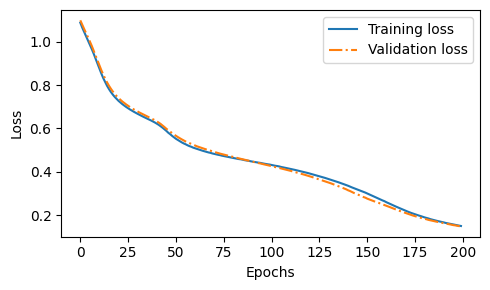

In [23]:
plot_values(num_epochs, train_losses, valid_losses)

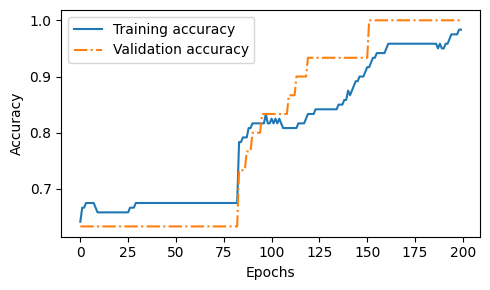

In [24]:
plot_values(num_epochs, train_accuracies, valid_accuracies, label="accuracy")